In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cvxpy as cp
import polytope as pc
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from cvxpylayers.torch import CvxpyLayer
from tqdm import tqdm
import matplotlib.pyplot as plt

from evanqp import CvxpyProblem, MPCProblem, Polytope, RandomSampler, FFNN, Verifier
from evanqp.layers import BoundArithmetic, BaseLayer, SeqLayer, LinearLayer, ReluLayer, QPLayer
from utils import dlqr

In [3]:
torch.manual_seed(4)
np.random.seed(4)

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

import latexify
latexify.latexify(fig_width=3.39/2)

In [4]:
class DCDCConverterRobust(MPCProblem):
    def __init__(self, N=20):
        self.N = N

        n = 2
        m = 1

        # Linearized dynamics
        self.A = np.array([[0.971356387900839, -0.009766890567613], [1.731870774203751, 0.970462385352837]])
        self.B = np.array([[0.148778899882612], [0.180827260808426]])
        self.C = np.array([[0, 1]])
        
        # Steady state
        ref = 5.0
        ss = np.linalg.solve(np.block([[self.A - np.eye(n), self.B],[self.C, 0]]), np.array([0, 0, ref]))
        self.xs = ss[0:2]
        self.us = ss[2:3]

        # Weights
        self.Q = np.diag([90, 1])
        self.R = np.array([[1]])
        self.K, self.P, _ = dlqr(self.A, self.B, self.Q, self.R)
        
        # Constraints
        self.x_max = np.array([0.2, 7.0])
        self.x_min = np.array([0.0, 0.0])
        self.u_max = np.array([1.0])
        self.u_min = np.array([0.0])
        
        # robust sets from MPT3
        robust_sets = sio.loadmat('robust_sets.mat')
        self.F_inf_A = robust_sets['F_inf_A']
        self.F_inf_b = robust_sets['F_inf_b'][:,0]
        self.X_tight_A = robust_sets['X_tight_A']
        self.X_tight_b = robust_sets['X_tight_b'][:,0]
        self.U_tight_A = robust_sets['U_tight_A']
        self.U_tight_b = robust_sets['U_tight_b'][:,0]
        
        # Terminal Set computation (shifted)
        # state constraints
        Hx = self.X_tight_A
        hx = self.X_tight_b - self.X_tight_A @ self.xs
        # input constraints
        Hu = self.U_tight_A
        hu = self.U_tight_b - self.U_tight_A @ self.us
        # closed loop dynamics
        Ak = self.A - self.B @ self.K
        # state & input constraints
        HH = np.vstack((Hx, -Hu @ self.K))
        hh = np.concatenate((hx, hu))
        # compute maximal invariant set
        O = pc.Polytope(HH, hh)
        while True:
            O_prev = O
            # pre-set
            O = O.intersect(pc.Polytope(O.A @ Ak, O.b))
            if O == O_prev:
                break
        self.F, self.f = O.A, O.b

        self.x0 = cp.Parameter(n, name='x0')
        self.z = cp.Variable((N + 1, n), name='z')
        self.u0 = cp.Variable(m, name='u0')
        self.v = cp.Variable((N, m), name='v')

        objective = cp.quad_form(self.z[N, :] - self.xs, self.P)
        constraints = [self.F_inf_A @ (self.x0 - self.z[0, :]) <= self.F_inf_b,
                       self.u0 == -self.K @ (self.x0 - self.z[0, :]) + self.v[0, :]]

        for i in range(N):
            objective += cp.quad_form(self.z[i, :] - self.xs, self.Q) + cp.quad_form(self.v[i, :] - self.us, self.R)
            constraints += [self.z[i + 1, :] == self.A @ self.z[i, :] + self.B @ self.v[i, :]]
            constraints += [self.X_tight_A @ self.z[i, :] <= self.X_tight_b]
            constraints += [self.U_tight_A @ self.v[i, :] <= self.U_tight_b]
        constraints += [self.F @ (self.z[N, :] - self.xs) <= self.f]

        self.objective = cp.Minimize(objective)
        self.prob = cp.Problem(self.objective, constraints)

    def problem(self):
        return self.prob

    def parameters(self):
        return [self.x0]

    def variables(self):
        return [self.u0]

    def solve(self, x0):
        self.x0.value = x0
        try:
            self.prob.solve(solver=cp.MOSEK)
        except:
            pass

        solution = {self.u0: self.u0.value,
                    self.z: self.z.value,
                    self.v: self.v.value,
                    self.objective: self.objective.value}
        return solution

    def reduced_objective(self):
        objective = cp.quad_form(self.z[self.N, :] - self.xs, self.P)
        for i in range(1, self.N):
            objective += cp.quad_form(self.z[i, :] - self.xs, self.Q) + cp.quad_form(self.v[i, :] - self.us, self.R)
        return cp.Minimize(objective)

In [5]:
mpc_controller = DCDCConverterRobust()

In [6]:
x1 = np.linspace(0, 0.2, 100)
x2 = np.linspace(0, 7, 100)
x, y = np.meshgrid(x1, x2)
z_opt = np.zeros(x.shape)
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        sol = mpc_controller.solve(np.array([x[i, j], y[i, j]]))
        u0 = sol[mpc_controller.variables()[0]]
        z_opt[i, j] = u0 if u0 is not None else None

100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


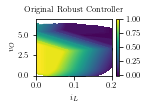

In [7]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_opt, levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
fig.colorbar(cs, ticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title('Original Robust Controller')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.savefig('figures/original_robust.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
parameter_set = Polytope(np.vstack((np.eye(2), -np.eye(2))), np.concatenate((mpc_controller.x_max, -mpc_controller.x_min)))

In [9]:
sampler = RandomSampler(mpc_controller, parameter_set)
parameter_samples, variable_samples = sampler.sample(5000, seed=1)

100%|██████████| 5000/5000 [01:51<00:00, 44.94it/s]


In [10]:
parameter_samples = torch.from_numpy(parameter_samples).float()
variable_samples  = torch.from_numpy(variable_samples).float()

torch.save(parameter_samples, 'parameter_samples_robust.pt')
torch.save(variable_samples, 'variable_samples_robust.pt')

In [7]:
parameter_samples = torch.load('parameter_samples_robust.pt')
variable_samples  = torch.load('variable_samples_robust.pt')

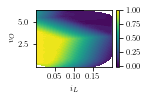

In [12]:
plt.tricontourf(parameter_samples.numpy()[:,0], parameter_samples.numpy()[:,1], variable_samples.numpy()[:,0], 50)
plt.colorbar(ticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title('Samples')
plt.xlabel(r'$i_L$')
plt.ylabel(r'$v_O$')
plt.show()

In [8]:
class DCDCConverterDataset(Dataset):
    def __init__(self, parameter_samples, variable_samples):
        self.parameter_samples = parameter_samples
        self.variable_samples = variable_samples

    def __len__(self):
        return self.parameter_samples.shape[0]

    def __getitem__(self, idx):
        return self.parameter_samples[idx, :], self.variable_samples[idx, :]

In [9]:
dataset = DCDCConverterDataset(parameter_samples, variable_samples)

seed = 1
train_set_ratio = 0.8

train_set_size = int(len(dataset) * train_set_ratio)
test_set_size = len(dataset) - train_set_size
train_set, test_set = random_split(dataset, [train_set_size, test_set_size], generator=torch.Generator().manual_seed(seed))

In [10]:
class SatModule(nn.Module):
    def __init__(self, num_features, x_min, x_max):
        super(SatModule, self).__init__()
        self.num_features = num_features
        self.x_min = x_min
        self.x_max = x_max
        
    def forward(self, x):
        return torch.max(torch.min(x, torch.from_numpy(self.x_max).float()), torch.from_numpy(self.x_min).float())
    
    def milp_layer(self, depth):
        return SeqLayer([
            LinearLayer(np.eye(self.num_features), -self.x_min, depth),
            ReluLayer(self.num_features, depth),
            LinearLayer(np.eye(self.num_features), self.x_min, depth),
            LinearLayer(-np.eye(self.num_features), self.x_max, depth),
            ReluLayer(self.num_features, depth),
            LinearLayer(-np.eye(self.num_features), self.x_max, depth)
        ], depth)

In [11]:
hidden_dim = 50

net = nn.Sequential(
    nn.Linear(mpc_controller.parameter_size(), hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, mpc_controller.variable_size()),
    # SatModule(mpc_controller.variable_size(), mpc_controller.u_min, mpc_controller.u_max)
)

In [12]:
def loss_function(model, data, target):
    output = model(data)
    loss = F.mse_loss(output, target)
    loss += 1e2 / len(data) * F.mse_loss(model(torch.from_numpy(mpc_controller.xs).float().to(data.device)), torch.from_numpy(mpc_controller.us).float().to(data.device))
    return loss

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        loss = loss_function(model, data, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # if batch_idx % 20 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data),
        #         len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)

In [14]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            test_loss += loss_function(model, data, target).item()

    test_loss /= len(test_loader)

    print('Epoch {} - Test set: Average loss: {:.6f}'.format(epoch, test_loss))

In [20]:
use_cuda = torch.cuda.is_available()

device = torch.device('cuda' if use_cuda else 'cpu')

train_kwargs = {'batch_size': 50}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    
train_loader = DataLoader(train_set, **train_kwargs)
test_loader = DataLoader(test_set, **test_kwargs)

In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(1, 250 + 1):
    train(net, device, train_loader, optimizer, epoch)
    test(net, device, test_loader, epoch)

Epoch 1 - Test set: Average loss: 0.101200
Epoch 2 - Test set: Average loss: 0.070127
Epoch 3 - Test set: Average loss: 0.048961
Epoch 4 - Test set: Average loss: 0.023467
Epoch 5 - Test set: Average loss: 0.008007
Epoch 6 - Test set: Average loss: 0.004638
Epoch 7 - Test set: Average loss: 0.003876
Epoch 8 - Test set: Average loss: 0.003711
Epoch 9 - Test set: Average loss: 0.003652
Epoch 10 - Test set: Average loss: 0.003413
Epoch 11 - Test set: Average loss: 0.003308
Epoch 12 - Test set: Average loss: 0.003240
Epoch 13 - Test set: Average loss: 0.003146
Epoch 14 - Test set: Average loss: 0.003111
Epoch 15 - Test set: Average loss: 0.002985
Epoch 16 - Test set: Average loss: 0.002954
Epoch 17 - Test set: Average loss: 0.002855
Epoch 18 - Test set: Average loss: 0.002813
Epoch 19 - Test set: Average loss: 0.002752
Epoch 20 - Test set: Average loss: 0.002721
Epoch 21 - Test set: Average loss: 0.002728
Epoch 22 - Test set: Average loss: 0.002628
Epoch 23 - Test set: Average loss: 0.0025

In [12]:
net_sat = nn.Sequential(
    *net,
    SatModule(mpc_controller.variable_size(), mpc_controller.u_min, mpc_controller.u_max)
)

In [23]:
torch.save({'state_dict': net_sat.state_dict()}, 'dc_dc_converter_qp_robust.pt')

In [13]:
saved_model = torch.load('dc_dc_converter_qp_robust.pt')
net_sat.load_state_dict(saved_model['state_dict'])

<All keys matched successfully>

In [25]:
z_net = np.vstack((x.flatten(), y.flatten())).T
z_net = net_sat(torch.from_numpy(z_net).float())
z_net = z_net.detach().cpu().numpy()
z_net = z_net.reshape(x.shape)

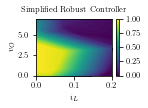

In [26]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, z_net, levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
fig.colorbar(cs, ticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title('Simplified Robust Controller')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.savefig('figures/simplified_robust.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

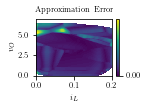

In [27]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
fig.colorbar(cs, ticks=[0, 0.25, 0.5, 0.75, 1])
ax.set_title('Approximation Error')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.show()

In [28]:
verifier = Verifier(parameter_set, mpc_controller, net_sat)

In [29]:
mpc_bounds, net_bounds = verifier.compute_bounds(method=BoundArithmetic.ZONO_ARITHMETIC)
print('Neural Network Bounds:')
print(f'lower bound: {net_bounds["lb"]}')
print(f'upper bound: {net_bounds["ub"]}')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-04


QP Output Bound: 100%|██████████| 1/1 [00:00<00:00, 160.57it/s]

Neural Network Bounds:
lower bound: [0.]
upper bound: [1.]


In [30]:
bound, parameters = verifier.approximation_error()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 1181 rows, 1079 columns and 5257 nonzeros
Model fingerprint: 0x60e73f80
Model has 670 general constraints
Variable types: 711 continuous, 368 integer (368 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [7e-18, 7e+00]
  RHS range        [3e-04, 7e+00]
  GenCon rhs range [2e-02, 7e+00]
  GenCon coe range [6e-02, 1e+00]

User MIP start produced solution with objective 0.0123133 (0.03s)
Loaded user MIP start with objective 0.0123133

Presolve removed 536 rows and 525 columns
Presolve time: 0.06s
Presolved: 645 rows, 554 columns, 4017 nonzeros
Presolved model has 106 SOS constraint(s)
Variable types: 381 continuous, 173 integer (173 binary)

Root relaxation: objective 1.000000e+00, 322 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    

In [31]:
print(f'Maximum absolute Error Bound between MPC and NN: {bound} at {parameters}')
u0_mpc = mpc_controller.solve(np.array(parameters))[mpc_controller.u0][0]
u0_net = net_sat(torch.from_numpy(np.array(parameters)).float()).detach().numpy()[0]
print(f'Double Checking by calulcaing error at this position: {u0_mpc - u0_net}')

Maximum absolute Error Bound between MPC and NN: 0.07253480593188463 at [0.0033869654306400462, 5.407118626739911]
Double Checking by calulcaing error at this position: -0.07251940421998138


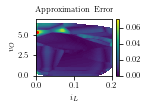

In [40]:
fig, ax = plt.subplots()
cs = ax.contourf(x, y, np.abs(z_opt - z_net), levels=100)
for c in cs.collections:
    c.set_edgecolor('face')
ax.plot(parameters[0], parameters[1], 'ro', markersize=2)
fig.colorbar(cs, ticks=[0, 0.02, 0.04, 0.06])
ax.set_title('Approximation Error')
ax.set_xlabel(r'$i_L$')
ax.set_ylabel(r'$v_O$')
plt.savefig('figures/approx_error_robust.pdf', bbox_inches='tight', pad_inches=0)
plt.show()